# ROI Head中的計算

In [ ]:
# 前面要先灌mmdetection
!pip install openmim
!mim install mmdet

## 1. ROI Head Rough Flow

ROI Head做的事情

**a. 先把要忽略的ground truth忽略掉, 沒有要忽略就填None**
``` python
if self.with_bbox or self.with_mask:
    num_imgs = len(img_metas)
    if gt_bboxes_ignore is None:
        gt_bboxes_ignore = [None for _ in range(num_imgs)]
```
**再來做sampling，for batch中每張照片**
``` python
    sampling_results = []
    neg_label_weights = []
    for i in range(num_imgs):
```
**b. Assign ground truth box給 各prediction box**
``` python  
    assign_result = self.bbox_assigner.assign(
        proposal_list[i], gt_bboxes[i], gt_bboxes_ignore[i],
        gt_labels[i])
```
**c. Sample 一些positive, negative做訓練**
``` python
    sampling_result = self.bbox_sampler.sample(
        assign_result,
        proposal_list[i],
        gt_bboxes[i],
        gt_labels[i],
        feats=[lvl_feat[i][None] for lvl_feat in x])
```
最後將sampling結果存list，供後續使用
``` python
    # neg label weight is obtained by sampling when using ISR-N
    neg_label_weight = None
    if isinstance(sampling_result, tuple):
        sampling_result, neg_label_weight = sampling_result
    sampling_results.append(sampling_result)
    neg_label_weights.append(neg_label_weight)
```

**d. ROI Pooling後預測bounding box**
```python
    # 將sample結果bounding box轉成ROI mask
    rois = bbox2roi([res.bboxes for res in sampling_results])
    # 將ROI Mask套用在feature map上
    bbox_results = self._bbox_forward(x, rois)
    cls_score = bbox_results['cls_score']
    bbox_pred = bbox_results['bbox_pred']
```
取得bounding box預測後對上相應的ground truth bounding box
```python
    bbox_targets = self.bbox_head.get_targets(sampling_results, gt_bboxes,
                                              gt_labels, self.train_cfg)
```
**e.使用ISR演算法將positive bbox對ground truth做attention**
```python
    isr_cfg = self.train_cfg.get('isr', None)
    if isr_cfg is not None:
        bbox_targets = isr_p(
            cls_score,
            bbox_pred,
            bbox_targets,
            rois,
            sampling_results,
            self.bbox_head.loss_cls,
            self.bbox_head.bbox_coder,
            **isr_cfg,
            num_class=self.bbox_head.num_classes)
    loss_bbox = self.bbox_head.loss(cls_score, bbox_pred, rois,
                                    *bbox_targets)
```
**f. 使用CARL演算法將negative bbox做attention**
```python
    carl_cfg = self.train_cfg.get('carl', None)
    if carl_cfg is not None:
        loss_carl = carl_loss(
            cls_score,
            bbox_targets[0],
            bbox_pred,
            bbox_targets[2],
            self.bbox_head.loss_bbox,
            **carl_cfg,
            num_class=self.bbox_head.num_classes)
        loss_bbox.update(loss_carl)

    bbox_results.update(loss_bbox=loss_bbox)
    return bbox_results
```

## 2.Proposal 與Ground Truth BBox計算IOU

In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
image=torch.zeros((128,128,3))

bbox = torch.tensor([[20, 20, 100, 100],],dtype=torch.int16) 
bbox_gt = torch.tensor([[60, 60, 100, 100],],dtype=torch.int16) 

In [3]:
from mmdet.core.bbox.iou_calculators.builder import build_iou_calculator
iou_calculator=build_iou_calculator({'type':'BboxOverlaps2D'})
def add_bbox(img,box,color,text):
    img=cv2.rectangle(img, box[:2].numpy(),box[2:].numpy(), color=color, thickness=1)
    plt.text(*box[:2].numpy(),
             text,
             color=color,
             fontsize ="large",
             verticalalignment="bottom")
def show_box_and_iou(image,bbox_pred,bbox_gt):
    # 轉換圖片成numpy格式
    plt.figure(figsize=(5,5))
    img=image.detach().cpu().numpy().copy()
    color_pred=(1,1,1)
    color_gt=(0,1,0)
    for n,box in enumerate(bbox_pred):
        add_bbox(img,box,color_pred,f"{n}")
    for n,box in enumerate(bbox_gt):
        add_bbox(img,box,color_gt,f"gt{n}")
    plt.imshow(img)
    overlaps =iou_calculator(bbox_gt.to(torch.float32),bbox_pred.to(torch.float32))
    plt.show()
    return overlaps

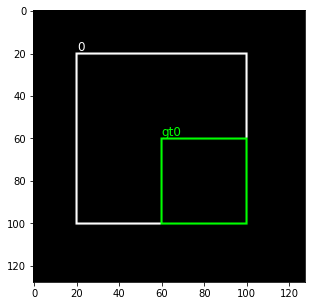

tensor([[0.2500]])

In [4]:
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

#### Exercise

可以感受一下不同prediction,ground truth組合的的iou

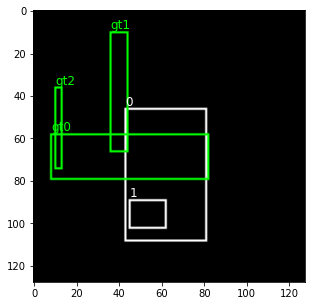

tensor([[0.2564, 0.0000],
        [0.0072, 0.0000],
        [0.0000, 0.0000]])

In [7]:
def rnd_bbox(frame_w=128,fram_h=128,amnt=6):
    x=torch.randint(5,frame_w-5,(amnt*2,))
    y=torch.randint(5,fram_h-5,(amnt*2,))
    xs=torch.stack((x[:amnt],x[amnt:]),-1)
    ys=torch.stack((y[:amnt],y[amnt:]),-1)
    x_mins=xs.min(dim=-1,keepdim=True).values
    y_mins=ys.min(dim=-1,keepdim=True).values
    x_maxs=xs.max(dim=-1,keepdim=True).values
    y_maxs=ys.max(dim=-1,keepdim=True).values
    boxes=torch.cat((x_mins,y_mins,x_maxs,y_maxs),dim=-1)
    return boxes
W=128
image=torch.zeros((W,W,3))
num_gts=3;num_bboxes=2
bbox=rnd_bbox(W,W,num_bboxes)
bbox_gt = rnd_bbox(W,W,num_gts)
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

為方便解說我們用固定的組合

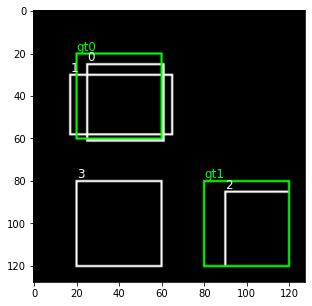

tensor([[0.7331, 0.6140, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6562, 0.0000]])

In [8]:
bbox = torch.tensor([[25, 25, 61, 61],
                        [17, 30, 65, 58],
                        [90, 85, 120, 120],
                        [20, 80, 60, 120]],dtype=torch.int16)
bbox_gt = torch.tensor([[20, 20, 60, 60],
                     [80, 80, 120, 120]],dtype=torch.int16) 
num_bboxes=len(bbox);num_gts=len(bbox_gt)
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

- 對於ground truth 0, 第0個proposal與他IOU最高
- 對於ground truth 1, 第2個proposal與他IOU最高

## 3.Ground Truth Assignment

下面是把每個proposal assign相對的ground truthoverlaps

In [9]:
# 1. assign -1 by default
assigned_gt_inds = overlaps.new_full((num_bboxes, ),-1,dtype=torch.long)
assigned_gt_inds

tensor([-1, -1, -1, -1])

In [10]:
# for each anchor, which gt best overlaps with it
# for each anchor, the max iou of all gts
max_overlaps, argmax_overlaps = overlaps.max(dim=0)
print(max_overlaps, argmax_overlaps )
# for each gt, which anchor best overlaps with it
# for each gt, the max iou of all proposals
gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)
print(gt_max_overlaps, gt_argmax_overlaps )

tensor([0.7331, 0.6140, 0.6562, 0.0000]) tensor([0, 0, 1, 0])
tensor([0.7331, 0.6562]) tensor([0, 2])


In [25]:
neg_iou_thr=0.3
# 2. assign negative: below the negative inds are set to be 0
if isinstance(neg_iou_thr, float):
    assigned_gt_inds[(max_overlaps >= 0)
                     & (max_overlaps < neg_iou_thr)] = 0
elif isinstance(neg_iou_thr, tuple):
    assert len(neg_iou_thr) == 2
    assigned_gt_inds[(max_overlaps >= neg_iou_thr[0])
                     & (max_overlaps < neg_iou_thr[1])] = 0
assigned_gt_inds

tensor([-1, -1, -1,  0])

In [26]:
pos_iou_thr=0.6
# 3. assign positive: above positive IoU threshold
pos_inds = max_overlaps >= pos_iou_thr
assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1
assigned_gt_inds

tensor([1, 1, 2, 0])

In [27]:
# Low-quality matching will overwrite the assigned_gt_inds assigned
# in Step 3. Thus, the assigned gt might not be the best one for
# prediction.
# For example, if bbox A has 0.9 and 0.8 iou with GT bbox 1 & 2,
# bbox 1 will be assigned as the best target for bbox A in step 3.
# However, if GT bbox 2's gt_argmax_overlaps = A, bbox A's
# assigned_gt_inds will be overwritten to be bbox B.
# This might be the reason that it is not used in ROI Heads.
min_pos_iou=0.3
gt_max_assign_all=True # by default
for i in range(num_gts):
    if gt_max_overlaps[i] >= min_pos_iou:
        if gt_max_assign_all:
            max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
            assigned_gt_inds[max_iou_inds] = i + 1
        else:
            assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1
assigned_gt_inds

tensor([1, 1, 2, 0])

最後若有class label的話將label assign上去

(前面在訓練RPN時也會用到，後面這段要到整個model output才有)

In [31]:
gt_labels=torch.tensor([0,1],dtype=torch.long) 
if gt_labels is not None:
    assigned_labels = assigned_gt_inds.new_full((num_bboxes, ), -1)
    pos_inds = torch.nonzero(
        assigned_gt_inds > 0, as_tuple=False).squeeze()
    if pos_inds.numel() > 0:
        assigned_labels[pos_inds] = gt_labels[
            assigned_gt_inds[pos_inds] - 1]
else:
    assigned_labels = None
assigned_labels

tensor([ 0,  0,  1, -1])

In [30]:
from mmdet.core.bbox.assigners import AssignResult
rslt=AssignResult(num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)
rslt.info

{'num_gts': 2,
 'num_preds': 4,
 'gt_inds': tensor([1, 1, 2, 0]),
 'max_overlaps': tensor([0.7331, 0.6140, 0.6562, 0.0000]),
 'labels': tensor([ 0,  0,  1, -1])}

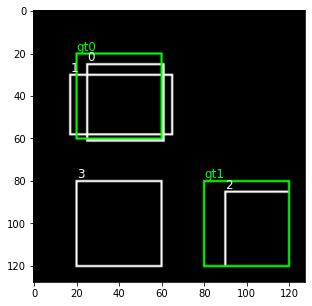

tensor([[0.7331, 0.6140, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6562, 0.0000]])

In [32]:
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

### 2. Importance-based Sample Reweighting(ISR)

PISA演算法對proposal做attention，稱做Importance-based Sample Reweighting(ISR)

會使用IOU的Hierarchical Local Rank(HLR)做為attention值參考來源

這邊其實還要跑ROI Pooling後的bounding box prediction才開始算，方便起見我們拿paper上的例子就好

<img src=https://i.imgur.com/65FacPS.png width="300">

[下列code來源於mmdetection中pisa loss的部分](https://github.com/open-mmlab/mmdetection/blob/5e246d5e3bc3310b5c625fb57bc03d2338ca39bc/mmdet/models/losses/pisa_loss.py)

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
pos_labels=torch.tensor([0,0],dtype=torch.int16)
max_l_num=pos_labels.bincount().max()

In [75]:
ious=[torch.tensor([.63,.52,.71],dtype=torch.float32),
      torch.tensor([.92,.5],dtype=torch.float32)]

In [69]:
_, t_iou_rank_idx=ious.sort(descending=True)

In [76]:
(pos_labels == label).nonzero().view(-1)

tensor([0, 1, 2, 3, 4])

In [77]:
l_inds

tensor([0, 1, 2, 3, 4])

In [66]:
label=pos_labels.unique():
l_inds = (pos_labels == label).nonzero().view(-1)
l_gts = gts[l_inds]
for t in l_gts.unique():
    t_inds = l_inds[l_gts == t]
    t_ious = ious[t_inds]
    _, t_iou_rank_idx = t_ious.sort(descending=True)
    _, t_iou_rank = t_iou_rank_idx.sort()
    ious[t_inds] += max_l_num - t_iou_rank.float()
l_ious = ious[l_inds]
_, l_iou_rank_idx = l_ious.sort(descending=True)
_, l_iou_rank = l_iou_rank_idx.sort()  # IoU-HLR
# linearly map HLR to label weights
pos_imp_weights[l_inds] *= (max_l_num - l_iou_rank.float()) / max_l_num

pos_imp_weights = (bias + pos_imp_weights * (1 - bias)).pow(k)

NameError: name 'gts' is not defined

取得排名之後會先使用最大值做正規化，然後再調整最低分數與銳利化，讓算值更偏向重要的proposal

In [11]:
# 正歸化
def normalize(rank,n_max=5):
    return (n_max-rank)/n_max
# 調整最低分數與銳利化
def sharpen(p,beta=0.,gamma=1.):
    return ((1.-beta)*p+beta)**gamma

用paper範例算出的rank來試試看

In [13]:
hl_rank=np.array([0,1,2,3,4])
hlr_score=normalize(hl_rank,n_max=4);print(hlr_score)
hlr_attention=sharpen(hlr_score,beta=0.5,gamma=3);print(hlr_attention)

[1.   0.75 0.5  0.25 0.  ]
[1.         0.66992188 0.421875   0.24414062 0.125     ]


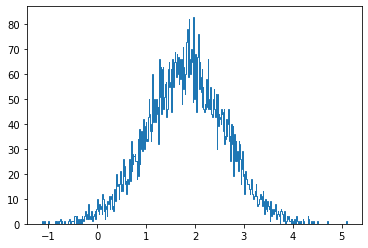

In [20]:
p=np.random.normal(loc=2.,size=(10000))
plt.hist(sharpen(p,beta=0.2,gamma=1),bins=500,histtype="step")
plt.show()

## Exercise

* 調整beta值看看對random normal亂數分布有何影響?

## Reference

* [PISA] Cao, Y., Chen, K., Loy, C. C., & Lin, D. (2020). Prime sample attention in object detection. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 11583-11591).